# FISTA to solve Discrete Optimal Transport

<div class="alert alert-block alert-success">
    
This notebook we aim at solving DOT instances using modern optimisation algorithms that outperform the simplex method. To do this we will use the FISTA framework. 
    
The notebook is divided in three parts. First, Condat's projection into the ℓ<sub>1</sub> ball algorithm is implemented. Second, the algorithm is used to find feasible solutions of DOT. Finally, the Primal Dual algorithm is tested. The results are automatically stored with an unique identifier and some performance plots are presented.
</div>

* Laurent Condat. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). _Also available at_ [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).



* V ̃u, B. (2011). <i>A splitting algorithm for dual monotone inclusions involving cocoercive operators </i>. Adv. Comput. Math, pages 667–681. [https://doi.org/10.1007/s10444-011-9254-8](https://doi.org/10.1007/s10444-011-9254-8).

<div class="alert alert-block alert-info">
Packages
</div>

In [1]:
import numpy  as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace, maximum, minimum
from numpy import asarray, add, subtract, multiply, clip
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm
from numpy.polynomial.chebyshev import chebpts1

In [2]:
from scipy.sparse import load_npz

# Algorithm

Now, we will run the Primal Dual algorithm addapted for DOT. To test it, we will run it against some of the DOTMark files. We will aim to transport from one given image to another, which are normalised and flattened in ```C```-order. The matrix of costs is based on a uniform grid within $[0,1]^2$ with $M$ points for the source and $N$ points for the target.

## Instance information

### Microscopy samples

In [3]:
folder = 'Microscopy_Sized'
path = 'Exact/' + folder + '/'

In [4]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data16_1002-data16_1010_p=S2',
 'data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

Select one instance:

In [5]:
instance = files[0]
full_path = path + instance

Load data:

In [6]:
m = np.load(full_path + '_m.npy');    M = m.size
n = np.load(full_path + '_n.npy');    N = n.size
c = np.load(full_path + '_Cost.npy')
sol = np.load(full_path + '_Sol.npy')

In [7]:
with open(full_path + '_Time.txt', 'r') as f:
    obj_exact = eval((f.readlines())[0])['Obj']

### Image samples

In [3]:
folder = 'Scalings'
path = 'Exact/' + folder + '/'

In [4]:
#files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
files = [f[:-6] for f in os.listdir(path) if f.endswith('.npy')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 10 instances in this location:


['I_16-16__p=S2',
 'I_16-16__p=S2',
 'I_4096-4096__p=S2',
 'I_4096-4096__p=S2',
 'I_1024-1024__p=S2',
 'I_1024-1024__p=S2',
 'I_256-256__p=S2',
 'I_256-256__p=S2',
 'I_64-64__p=S2',
 'I_64-64__p=S2']

Select one instance:

In [15]:
instance = files[0]
full_path = path + instance

Load data:

In [16]:
m = np.load(full_path + '_m.npy');    M = m.size
n = np.load(full_path + '_n.npy');    N = n.size
c = np.load(full_path + '_Cost.npz')['c']
sol = load_npz(full_path + '_Sol.npz').A

In [17]:
obj_exact = (c * sol).sum();

## Run algorithm

<div class="alert alert-block alert-warning">
    
In what follows, we provide tests for the chosen instance running the convergent FISTA approach given by Antonin Chambolle and Charles Dossal (2015) adapted to its linesearch version as in Amir Beck and Marc Teboulle (2018). 
The projection operator to solve the Projection Onto Convex Sets problem is the Dykstra’s projection method found in Patrick Combettes and Jean-Christophe Pesquet (2011) and it will be tested against the method of Combettes, Dung and Vu (2010). This requires the use of the double marginal projection which is found in Mai et al (2021).
    
    
* Amir Beck and Marc Teboulle (2009). <i>A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems</i>. SIAM J. Imaging Sciences, pp 183–202. [https://doi.org/10.1137/080716542](https://doi.org/10.1137/080716542).
    
* Antonin Chambolle and Charles Dossal (2015). <i>On the convergence of the iterates of ”FISTA”</i>. Journal of Optimization Theory and Applications, pp 968–982. [https://doi.org/10.1007/s10957-015-0746-4](https://doi.org/10.1007/s10957-015-0746-4)
    
* Vien V. Mai, Jacob Lindbäck, Mikael Johansson. (2021). <i>A Fast and Accurate Splitting Method for Optimal Transport: Analysis and Implementation</i>. arXiV preprint. [https://doi.org/10.48550/arXiv.2110.11738](https://doi.org/10.48550/arXiv.2110.11738).
    
* Patrick Combettes, Ðinh Dũng, and Bằng Công Vũ  (2010). <i>Proximity for sums of composite functions</i>. Journal of Mathematical Analysis and Applications, pp 680–688. [https://doi.org/10.1016/j.jmaa.2011.02.079](https://doi.org/10.1016/j.jmaa.2011.02.079)
    
* Patrick Combettes and Jean-Christophe Pesquet (2011). <i>Proximal Splitting Methods in Signal Processing</i>. In: Bauschke, H., Burachik, R., Combettes, P., Elser, V., Luke, D., Wolkowicz, H. (eds) Fixed-Point Algorithms for Inverse Problems in Science and Engineering. Springer Optimization and Its Applications(), vol 49. Springer, New York, NY. [https://doi.org/10.1007/978-1-4419-9569-8_10](https://doi.org/10.1007/978-1-4419-9569-8_10).
    
* Yura Malitsky and Thomas Pock. (2018). <i>A first-order primal-dual algorithm with linesearch</i>. SIAM Journal on Optimization, pp 411–432. [https://doi.org/10.1137/16M1092015](https://doi.org/10.1137/16M1092015).
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Fast Iterative Shrinkage-Thresholding Algorithm with backtracking</h2>
<ol>
<li>Let $x_0 = y_0 \in \mathcal{C}$, $\theta_0 = 1$, $L_0>0$, and $\eta > 1$.</li>
<li>
    For any $L>0$ and $x,y \in \mathcal{C}$, define the functions
    \begin{align}
        p_L (y) &= \mathcal{P}_{\mathcal{C}}[y - L^{-1} c ],
    \\
        q_L (y,x) &= c:x + \langle y-x, c \rangle + \frac{L}{2} \|y-x\|^2.
    \end{align}
</li>
    
<li>For $k \in \{0,\ldots\}$, do
<ol>

<li>Find the smallest $i_k \in \mathbb{N}$ such that
\begin{align}
    L &= \eta^{i_k} L_k
    \\
    c: p_L (y_k) &\leq q_L \big( p_L(y_k), y_k  \big)
\end{align}
    
<li>Update $L_{k+1} = \eta^{i_k} L_k$
<li>Set $x_{k+1} = p_{L_{k+1}} (y_k)$
<li>Update $\theta_{k+1} = \frac{5}{11}k + 1$
<li>Update $y_{k+1} = x_{k+1} + \frac{\theta_k - 1}{\theta_{k+1}} (x_{k+1} - x_k)$
</li>
</ol>
</div>

Remember that we have defined $\mathcal{C}$ as the following set of real-valued matrices with prescribed row and column sums; i.e.,
$
    \mathcal{C} := 
    \big\{
        u \in \mathbb{R}^{M\times N}_{\geq 0}:\,   u \mathbb{1}_N = m 
        \,\,\text{ and }\,\,
        \mathbb{1}_M u = n
    \big\}
$;
where $\mathbb{1}_s$ is a vector of ones of size $s$.

Any projection evaluation via $p_L$ requires a POCS problem to be solved, which has no exact solution. Let us define the marginal set
$
    \mathcal{X} := 
    \big\{
        u \in \mathbb{R}^{M\times N}:\,   u \mathbb{1}_N = m 
        \,\,\text{ and }\,\,
        \mathbb{1}_M u = n
    \big\}
$.
Then we get that $\mathcal{C} = \mathcal{X} \cap \mathbb{R}^{M\times N}_{\geq 0}$. Both are closed and convex sets, thus we can use any POCS method to find a projection onto their intersection. Moreover, we have closed formulas for the projection onto both sets.

The projection on $\mathcal{X}$ is of the form $\mathrm{proj}_{\mathcal{X}}(u) = u - G(u)$, where $G$ is computed as follows:

1. $\kappa_1 = u\mathbb{1}_{N} - m$,
2. $\beta_1 = \langle \kappa_1, \mathbb{1}_M \rangle \big/ (M+N)$,
3. $\kappa_2 = \mathbb{1}_{M}u - n$,
4. $\beta_2 = \langle \kappa_2, \mathbb{1}_N \rangle \big/ (M+N)$,
5. $G(u) = \frac{1}{N}(\kappa_1 - \beta_1)\mathbb{1}_{N}^\top + \frac{1}{M} \mathbb{1}_{M}( \kappa_2 - \beta_2 )^\top $.


The projection on $\mathbb{R}^{M\times N}_{\geq 0}$ is just 
$\mathrm{proj}_{\mathbb{R}^{M\times N}_{\geq 0}} (u) = [u]_+$. Both operations can be carried out in a quick fashion.

Observe that by the form of $\mathrm{proj}_{\mathcal{X}}(u)$, we have that
\begin{align}
    \theta\, \mathrm{proj}_{\mathcal{X}}(\theta^{-1} v + y)
    &= (v + \theta y) - \theta \, G(\theta^{-1} v + y)
\end{align}
As a result
\begin{align}
    \theta y - \theta\, \mathrm{proj}_{\mathcal{X}}(\theta^{-1} v + y)
    &= -v + \theta \, G(\theta^{-1} v + y)
\end{align}

We know that $[u]_+ = \max\{u,0\} = \frac{1}{2} (u + |u|)$. In this setting, we have that
\begin{align}
    \theta\, [\theta^{-1} v + y]_+ = \frac{1}{2} ( v + \theta y ) + \frac{1}{2} | v + \theta y|
    = [v + \theta y]_+
\end{align}
On the other hand, we also have that $[u]_- = \min\{u,0\} = \frac{1}{2} (u - |u|)$. Hence we arrive at
\begin{align}
    \theta y - \theta [\theta^{-1} v + y]_+ &= \theta y - [v + \theta y]_+
    \\
    &= (v+\theta y) - \frac{1}{2} \big( (v + \theta y) + |v + \theta y|  \big) - v
    \\
    &= \frac{1}{2} \big( (v + \theta y) - |v + \theta y|  \big) - v
    \\
    &= [v + \theta y]_- - v.
\end{align}

As a result we obtain that steps C and D can be simplified to
\begin{align}
    v_{1,k+1} &= \theta_k \, G(\theta_k^{-1} v_{1,k+1} + y_k)
    \\
    v_{2,k+1} &= [v_{2,k} + \theta_k y_k]_-
\end{align}

In [8]:
def Marginal_G(u):
    κₘ = u.sum(1) - m
    κₙ = u.sum(0) - n

    βₘ = κₘ.sum() / (M + N)        # dim M
    βₙ = κₙ.sum() / (M + N)        # dim N

    # Implicit yₖ = ( (κₘ - βₘ)/N).reshape(M,1) + (κₙ - βₙ)/M
    ϕ = (1/N) * (κₘ - βₘ)
    ψ = (1/M) * (κₙ - βₙ)
    
    return ϕ, ψ

In [9]:
#c - G(c)
#(c - Marginal_G(c)[0] - Marginal_G(c)[1].reshape(M,1)).sum(0) - m
#(c - Marginal_G(c)[0] - Marginal_G(c)[1].reshape(M,1)).sum(1) - n
#subtract(c,ψ, out=p);    subtract(p,ϕ.reshape(M,1), out=p)

In [9]:
# Start with a feasible point
yₖ, v_2, uₖ = zeros((3,M,N));
z = zeros((M,N));

# Project v_1 for feasibility
ϕ, ψ = Marginal_G(v_2)
#subtract(v_1,ψ, out=v_1);    subtract(v_1,ϕ.reshape(M,1), out=v_1);
# v_2 is already feasible

In [10]:
# ε is selected as a small number
ε = 0.5

# Define theta as a fixed value
θ = 2 - ε
θ̂ = 1/θ

In [11]:
Errors = {'m':[], 'n':[], '<0':[], '>1':[]}

In [12]:
for i in range(10000):
    #y = z - 0.5 * (v_1 + v_2)
    subtract(z, 0.5 * v_2, out = yₖ);
    subtract(yₖ, 0.5 * ψ, out=yₖ);
    subtract(yₖ, 0.5 * ϕ.reshape(M,1), out=yₖ);
    
    # Update pair for v_1: θ G(yₖ + θ̂ v_1)
    add(yₖ, θ̂ * ψ, uₖ);
    add(uₖ, θ̂ * ϕ.reshape(M,1), uₖ);
    ϕ, ψ = Marginal_G( uₖ )
    ψ *= θ
    ϕ *= θ

    # Update v_2
    minimum(0, v_2 + θ*yₖ, out = v_2);

    
    # Test error
    r, s = yₖ.sum(1) - m, yₖ.sum(0) - n
    
    # Constrained satisfactibility
    Errors['m'].append( norm(r)/norm(m) )
    Errors['n'].append( norm(s)/norm(n) )
    Errors['<0'].append( (yₖ < 0.0).any() )
    Errors['>1'].append( (yₖ > 1.0).any() )
    
    if max(Errors['m'][-1], Errors['n'][-1]) < 1e-13:
        break

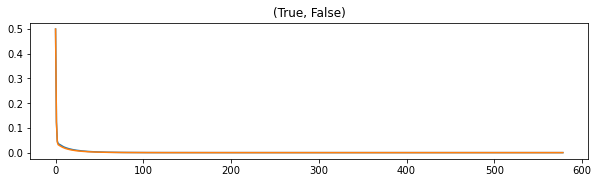

In [13]:
plt.figure(figsize=(10,2.5))
plt.plot(Errors['m'])
plt.plot(Errors['n'])
plt.title( (any(Errors['<0']), any(Errors['>1'])) )
plt.show()

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Dykstra’s projection method</h2>
<ol>
<li>Let $z \in \mathbb{R}^{M\times N}$
<li>Set $x_0 = z$, $p_0 = 0$, $q_0 = 0$, and $k=0$.
<li>While $x_k\notin \mathcal{C}$, do
<ol>
<li>$y_k = \mathrm{proj}_{\mathcal{X}}( x_k + p_k) = (x_k + p_k) - G(x_k+p_k)$
<li>$p_{k+1} = (x_k + p_k) - y_k = G(x_k+p_k)$
<li>$x_{k+1} = [y_k + q_k ]_+$
<li>$q_{k+1} = (y_k + q_k) - x_{k+1} = [y_k + q_k]_-$
    
<li>$k = k+1$
</div>

Observe that steps `A` and `B` can be replaced with

1. $u_k = x_k + p_k$
2. $p_{k+1} = G(u_k)$
3. $y_k = u_k - p_{k+1}$

In [14]:
# Initialise variables
xₖ = zeros((M,N));
qₖ, uₖ, yₖ, vₖ = zeros((4,M,N));
ϕ = zeros(M);
ψ = zeros(N);

In [15]:
Errors = {'m':[], 'n':[], '<0':[], '>1':[]}

In [16]:
# Dykstra’s projection method
for i in range(4000):
    # Store xₖ + pₖ
    add(xₖ,ψ,uₖ);        add(uₖ, ϕ.reshape(M,1), uₖ);    #uₖ = xₖ + ϕ.reshape(M,1) + ψ
    # Update sparse representation of pₖ
    ϕ, ψ = Marginal_G(uₖ)
    # Update yₖ = uₖ - pₖ
    subtract(uₖ,ψ,yₖ);   subtract(yₖ, ϕ.reshape(M,1), yₖ);    #yₖ = uₖ - ψ - ϕ.reshape(M,1)
    # Store yₖ + qₖ
    add(yₖ,qₖ,vₖ);
    # Update xₖ = [yₖ + qₖ]_+
    maximum(vₖ, 0.0, xₖ);
    # Update qₖ = [yₖ + qₖ]_-
    minimum(vₖ, 0.0, qₖ);
    
    # Test error
    r, s = xₖ.sum(1) - m, xₖ.sum(0) - n
    
    # Constrained satisfactibility
    Errors['m'].append( norm(r)/norm(m) )
    Errors['n'].append( norm(s)/norm(n) )
    Errors['<0'].append( (xₖ < 0.0).any() )
    Errors['>1'].append( (xₖ > 1.0).any() )
    
    if max(Errors['m'][-1], Errors['n'][-1]) < 1e-13:
        break

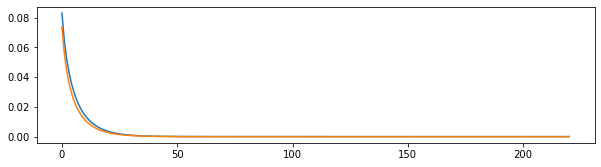

In [17]:
plt.figure(figsize=(10,2.5))
plt.plot(Errors['m'])
plt.plot(Errors['n'])
plt.show()

In [18]:
allclose(np.diff(Errors['m'])[2000:],0.0)

True

It seems that Dykstra's algorithm is superior! We will use it for computing projections from now on.

In [383]:
def prox_C(z, its = 4000, tol = 1e-13):
    # x = prox_C(z,its,tol) : Computes proximal of the indicator function of the 
    # intersection of the simpleces governed by m and n, respectively.
    #
    # x satisfies sum(x,1) ~ m' and sum(x,2) ~ n with tolerance `tol` and is nonnegative.
    #
    
    # Initialise variables
    xₖ = z.copy()
    qₖ, uₖ, yₖ, vₖ = zeros((4,M,N));
    zₖ = zeros((M,N));
    ϕ = zeros(M);
    ψ = zeros(N);
    
    # Dykstra’s projection method
    for i in range(its):
        # Store previous xₖ
        zₖ = xₖ.copy()
        
        # Store xₖ + pₖ
        add(xₖ,ψ,uₖ);        add(uₖ, ϕ.reshape(M,1), uₖ);    #uₖ = xₖ + ϕ.reshape(M,1) + ψ
        # Update sparse representation of pₖ
        ϕ, ψ = Marginal_G(uₖ)
        # Update yₖ = uₖ - pₖ
        subtract(uₖ,ψ,yₖ);   subtract(yₖ, ϕ.reshape(M,1), yₖ);    #yₖ = uₖ - ψ - ϕ.reshape(M,1)
        # Store yₖ + qₖ
        add(yₖ,qₖ,vₖ);
        # Update xₖ = [yₖ + qₖ]_+
        maximum(vₖ, 0.0, xₖ);
        # Update qₖ = [yₖ + qₖ]_-
        minimum(vₖ, 0.0, qₖ);

        # Test error
        r, s = xₖ.sum(1) - m, xₖ.sum(0) - n

        # Constrained satisfactibility
        if max(norm(r)/norm(m), norm(s)/norm(n)) < tol:
            break
        # Iterate
        if norm(zₖ - xₖ) < tol:
            break
            
    #print(norm(zₖ - xₖ))
    return xₖ #, ϕ, ψ, i

9.998453985975829e-14


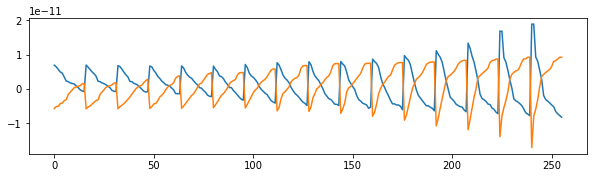

(9.91385193759509e-10, 9.402121829628406e-10)

In [378]:
xₖ, ϕ, ψ, i = prox_C(x-1/c.sum() * c, its = 50000, tol = 1e-13)
r, s = xₖ.sum(1) - m, xₖ.sum(0) - n
plt.figure(figsize=(10,2.5))
plt.plot(r)
plt.plot(s)
plt.show()
norm(r)/norm(m), norm(s)/norm(n)

In [379]:
i, 2.22469413858155e-12

(44786, 2.22469413858155e-12)

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Fast Iterative Shrinkage-Thresholding Algorithm</h2>
<ol>
<li>Let $L$ be a Lipschitz constant of $\nabla f(x) = \nabla (c:x) = c$.
<li>
    For $y \in \mathbb{R}^{M\times N}$, define the function
    \begin{align}
        p_L (y) &= \mathrm{proj}_{\mathcal{C}}[y - L^{-1} c ].
    \end{align}
</li>
    
<li>Take $y_0 = x_0 \in \mathbb{R}^{M\times N}$, $\theta_0 = 1$, $\alpha > 2$
<li>For $k \in \{0,\ldots\}$, do
<ol>

<li>$x_{k+1} = p_{L} (y_k)$
<li>$\theta_{k+1} = \frac{k + \alpha}{\alpha}$
<li>$y_{k+1} = x_{k+1} + \frac{\theta_k - 1}{\theta_{k+1}} (x_{k+1} - x_k)$
</li>
</ol>
</div>

Observe that $f$ is a $\infty$-Lipschitz function, so technically we could take any value of $L$ for the algorithm above. However, numerical experiments have shown us that $\mathrm{proj}_{u}$ displays quick convergence whenever $\|u\|_1 \leq 1$. As a result, we will test our algorithm with $L = \|c\|_1$. Notwithstanding, we could further try setting $L_k = \|c\|_1 / | \|y_k\| - 1 |$, which would point towards every step to be projected behaving in a similar fashion.

**Test 1:** $L = \|c\|_1$:

In [279]:
def FISTA(c,m,n,iters, collect_obj = False, true_obj = None, 
                         true_obj_tol = 1e-4, true_solution = None, save_iter = False, 
                         guess_x = None,  guess_y = None, show = False, disp_iterator = 20,
                         prox_its = 4000, prox_tol = 1e-13,
                         Li = None, a = 11/5):
    # Algorithm for calculating solution x, in the primal space
    # and y = [ψ, ϕ] in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    
    '''
        Initialise parameters
    '''
    
    # Fetch lengths of m and n
    N = n.size
    M = m.size
    
    # Initialise L^{-1}
    Li = (1/c.sum()) if Li is None else Li
    # Check a
    if a < 2:
        print('Warning! a should be at least 2!!')
    
    # Initialise θ
    #θ = 1.0

    if show:
        print('\n*** FISTA with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    # Initialise x & y
    x = guess_x.copy() if (guess_x is not None) else zeros((M,N))
    y = guess_y.copy() if (guess_y is not None) else zeros((M,N))
        
    # Initialise previous copy of x
    u = x.copy()
        
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [ (c*x).sum() ]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        if show:
            print('Objective from ground truth:', obj_exact,'\n')
            
        
    '''
        Iterate the Primal Dual scheme
    '''
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 'l_1':[],
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'l_1':[]}
    
    if true_solution is not None:
        if show:
            print('     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  ')
            print( '{:-^66}'.format('') )
        
    timed = 0.0
    
    
    for k in range(1,iters):
        it_time = time.time()
        
        # ** Proximal step **
        x = prox_C(y - Li * c, prox_its, prox_tol)
        
        # Inertia (θₚ - 1)/θ
        α = k/( a + k + 1 )
        
        # Momentum        y = x + α * (x - u)
        subtract(x,u,y)
        y *= α
        add(x,y,y)
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Recover values from mask
        ℓ_1 = norm(x.ravel(),1)
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
                
                
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - m, x.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(u-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            every_iter['l_1'].append(ℓ_1)
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if (dist_true_sol < true_obj_crit) or (k%disp_iterator == 0):
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                every_critical['l_1'].append(ℓ_1)

                if show:
                    print('* {0:6.0f} |   {1:.1e} |  {2:1.1e}  | {3:8.2f} s |   {4:4.4f} |  {5:4.4f}'.format(k,
                                                                            true_obj_crit,
                                                                            dist_true_sol,
                                                                            timed,frob_d,ℓ_1))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    if show:
                        print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                if (dist_true_sol < true_obj_crit):
                    true_obj_crit *= 0.1
                
        # Update previous step
        u = x.copy()
    
    if true_solution is not None:
        if show:
            print( '{:-^66}'.format('') )

    if show:
        print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    if collect_obj == False and save_iter == True:
        return x, y, every_iter
    if collect_obj == True and save_iter == True:
        return x, y, obj, every_critical, every_iter
    else:
        return x

In [281]:
x, y, obj, every_critical, every_iter = FISTA(c,m,n, 2001, collect_obj = True, 
                                                true_obj = obj_exact, true_obj_tol = 1e-20, show = True,
                                                true_solution = sol, save_iter = True, disp_iterator = 50,
                                                                Li = 1/c.sum(), a = 11/5)


*** FISTA with M = 256, N = 256, MN = 65536 ***


Objective from ground truth: 0.01188861757518317 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*     47 |   1.0e+00 |  9.8e-01  |    31.08 s |   0.9081 |  1.0000
*     50 |   1.0e-01 |  9.1e-01  |    34.21 s |   0.9031 |  1.0000
*    100 |   1.0e-01 |  4.0e-01  |    87.07 s |   0.8241 |  1.0000
*    150 |   1.0e-01 |  2.3e-01  |   141.11 s |   0.7505 |  1.0000
*    200 |   1.0e-01 |  1.4e-01  |   194.11 s |   0.6825 |  1.0000
*    241 |   1.0e-01 |  1.0e-01  |   237.11 s |   0.6316 |  1.0000
*    250 |   1.0e-02 |  9.2e-02  |   246.52 s |   0.6210 |  1.0000
*    300 |   1.0e-02 |  6.1e-02  |   300.84 s |   0.5665 |  1.0000
*    350 |   1.0e-02 |  4.0e-02  |   353.27 s |   0.5188 |  1.0000
*    400 |   1.0e-02 |  2.5e-02  |   405.88 s |   0.4797 |  1.0000
*    450 |   1.0e-02 |  1.5e-02  |   458.65 s |   0.4488 |  1.0000
*    489 |   1.0e-02 |  1.

In [384]:
x, y, obj, every_critical, every_iter = FISTA(c,m,n, 201, collect_obj = True, 
                                                true_obj = obj_exact, true_obj_tol = 1e-20, show = True,
                                                true_solution = sol, save_iter = True, disp_iterator = 20,
                                                prox_its = 50000,
                                                                Li = 1/c.sum(), a = 11/5)


*** FISTA with M = 256, N = 256, MN = 65536 ***


Objective from ground truth: 0.01188861757518317 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*     20 |   1.0e+00 |  2.4e+00  |     4.49 s |   0.9545 |  1.0000
*     40 |   1.0e+00 |  1.2e+00  |    24.28 s |   0.9198 |  1.0000
*     47 |   1.0e+00 |  9.8e-01  |    35.66 s |   0.9081 |  1.0000
*     60 |   1.0e-01 |  7.4e-01  |    65.34 s |   0.8868 |  1.0000
*     80 |   1.0e-01 |  5.3e-01  |   139.04 s |   0.8549 |  1.0000
*    100 |   1.0e-01 |  4.0e-01  |   245.53 s |   0.8241 |  1.0000
*    120 |   1.0e-01 |  3.1e-01  |   387.19 s |   0.7940 |  1.0000
*    140 |   1.0e-01 |  2.5e-01  |   560.24 s |   0.7648 |  1.0000
*    160 |   1.0e-01 |  2.1e-01  |   767.83 s |   0.7364 |  1.0000
*    180 |   1.0e-01 |  1.7e-01  |  1016.95 s |   0.7090 |  1.0000
*    200 |   1.0e-01 |  1.4e-01  |  1305.49 s |   0.6825 |  1.0000
--------------------------

Restart?

In [299]:
def Restart_FISTA(c,m,n,iters, collect_obj = False, true_obj = None, 
                         true_obj_tol = 1e-4, true_solution = None, save_iter = False, 
                         guess_x = None,  guess_y = None, show = False, disp_iterator = 20,
                         prox_its = 4000, prox_tol = 1e-13,
                         Li = None, a = 11/5):
    # Algorithm for calculating solution x, in the primal space
    # and y = [ψ, ϕ] in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    
    '''
        Initialise parameters
    '''
    
    # Fetch lengths of m and n
    N = n.size
    M = m.size
    
    # Initialise L^{-1}
    Li = (1/c.sum()) if Li is None else Li
    # Check a
    if a < 2:
        print('Warning! a should be at least 2!!')
    
    # Initialise θ
    #θ = 1.0

    if show:
        print('\n*** FISTA with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    
    '''
        Initialise matrices
    '''
    # Initialise x & y
    x = guess_x.copy() if (guess_x is not None) else zeros((M,N))
    y = guess_y.copy() if (guess_y is not None) else zeros((M,N))
        
    # Initialise previous copy of x
    u = x.copy()
        
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [ (c*x).sum() ]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        if show:
            print('Objective from ground truth:', obj_exact,'\n')
            
        
    '''
        Iterate the Primal Dual scheme
    '''
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 'l_1':[],
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'l_1':[]}
    
    if true_solution is not None:
        if show:
            print('     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  ')
            print( '{:-^66}'.format('') )
        
    timed = 0.0
    
    
    t = 0
    for k in range(1,iters):
        it_time = time.time()
        
        # ** Proximal step **
        x = prox_C(y - Li * c, prox_its, prox_tol)
        
        # Inertia (θₚ - 1)/θ
        α = (k-t)/( a + (k-t) + 1 )
        
        # Momentum        y = x + α * (x - u)
        subtract(x,u,y)
        y *= α
        add(x,y,y)
        
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Recover values from mask
        ℓ_1 = norm(x.ravel(),1)
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
                
                
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - m, x.sum(0) - n
            
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(u-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            every_iter['l_1'].append(ℓ_1)
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(m) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(m,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(m,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(n) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(n,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(n,1e-7)).min() )
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if (dist_true_sol < true_obj_crit) or (k%disp_iterator == 0):
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                every_critical['l_1'].append(ℓ_1)

                if show:
                    print('* {0:6.0f} |   {1:.1e} |  {2:1.1e}  | {3:8.2f} s |   {4:4.4f} |  {5:4.4f}'.format(k,
                                                                            true_obj_crit,
                                                                            dist_true_sol,
                                                                            timed,frob_d,ℓ_1))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    if show:
                        print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                if (dist_true_sol < true_obj_crit):
                    true_obj_crit *= 0.1
                
        # Restart check:
        if obj[-1] - obj[-2] > 0:
            y = x.copy()
            t = k
        
        # Update previous step
        u = x.copy()
    
    if true_solution is not None:
        if show:
            print( '{:-^66}'.format('') )

    if show:
        print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    if collect_obj == False and save_iter == True:
        return x, y, every_iter
    if collect_obj == True and save_iter == True:
        return x, y, obj, every_critical, every_iter
    else:
        return x

In [300]:
x, y, obj, every_critical, every_iter = Restart_FISTA(c,m,n, 2001, collect_obj = True, 
                                                true_obj = obj_exact, true_obj_tol = 1e-20, show = True,
                                                true_solution = sol, save_iter = True, disp_iterator = 50,
                                                prox_its = 10000,
                                                                Li = 1/c.sum(), a = 11/5)


*** FISTA with M = 256, N = 256, MN = 65536 ***


Objective from ground truth: 0.01188861757518317 

     It  | Tolerance |  obj dist |    Time    | ‖x-x*‖_F |  ‖x‖_1  
------------------------------------------------------------------
*     47 |   1.0e+00 |  1.0e+00  |    39.84 s |   0.9096 |  1.0000
*     50 |   1.0e-01 |  9.3e-01  |    46.94 s |   0.9047 |  1.0000
*    100 |   1.0e-01 |  4.0e-01  |   178.65 s |   0.8255 |  1.0000
*    150 |   1.0e-01 |  2.3e-01  |   310.44 s |   0.7518 |  1.0000
*    200 |   1.0e-01 |  1.4e-01  |   442.07 s |   0.6838 |  1.0000
*    242 |   1.0e-01 |  1.0e-01  |   552.74 s |   0.6316 |  1.0000
*    250 |   1.0e-02 |  9.3e-02  |   573.83 s |   0.6222 |  1.0000
*    300 |   1.0e-02 |  6.1e-02  |   705.60 s |   0.5675 |  1.0000
*    350 |   1.0e-02 |  4.1e-02  |   837.31 s |   0.5196 |  1.0000
*    400 |   1.0e-02 |  2.5e-02  |   969.46 s |   0.4803 |  1.0000
*    450 |   1.0e-02 |  1.5e-02  |  1101.07 s |   0.4494 |  1.0000
*    491 |   1.0e-02 |  1.

---

Just for reference, these are the errors related to the satisfactibility of the solution:

In [42]:
r, s = sol.sum(1) - m, sol.sum(0) - n

In [43]:
# Print error estimates
print('ℓ-error | r = x̄ 𝟙ₙ - m |      r/m     | s = 𝟙ₘ x̄ - n |      s/n ')
print( '{:-^67}'.format('') )
print('   1    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
            norm(r,1), norm(r/maximum(m,1e-7),1), norm(s,1), norm(s/maximum(n,1e-7),1) ))
print('   2    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
                            norm(r), norm(r/maximum(m,1e-7)), norm(s), norm(s/maximum(n,1e-7)) ))
print('   ∞    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
            norm(r,np.inf), norm(r/maximum(m,1e-7),np.inf), norm(s,np.inf), norm(s/maximum(n,1e-7),np.inf) ))
print('  -∞    | {0:1.6e} | {1:1.6e} | {2:1.6e} | {3:1.6e} '.format(
            abs(r).min(), abs(r/maximum(m,1e-7)).min(), abs(s).min(), abs(s/maximum(m,1e-7)).min() ))
print( '{:-^67}'.format('') )

ℓ-error | r = x̄ 𝟙ₙ - m |      r/m     | s = 𝟙ₘ x̄ - n |      s/n 
-------------------------------------------------------------------
   1    | 7.979728e-17 | 2.447586e-15 | 1.908196e-17 | 6.651720e-16 
   2    | 5.663812e-17 | 1.593472e-15 | 9.341772e-18 | 2.990516e-16 
   ∞    | 5.551115e-17 | 1.550475e-15 | 6.938894e-18 | 1.558086e-16 
  -∞    | 0.000000e+00 | 0.000000e+00 | 0.000000e+00 | 0.000000e+00 
-------------------------------------------------------------------


## Visualise and store results

In [44]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'APD-'

In [45]:
# Check if main folder for results exists, else create it
if not os.path.exists(main_folder):    os.makedirs(main_folder)
# Now create a folder for the results of the instance
if not os.path.exists(out_folder):    os.makedirs(out_folder)
out_folder += '/' + algorithm

In [ ]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

#plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [107]:
if 'γ' not in locals():
    γ = 1

In [111]:
εₐ = 0

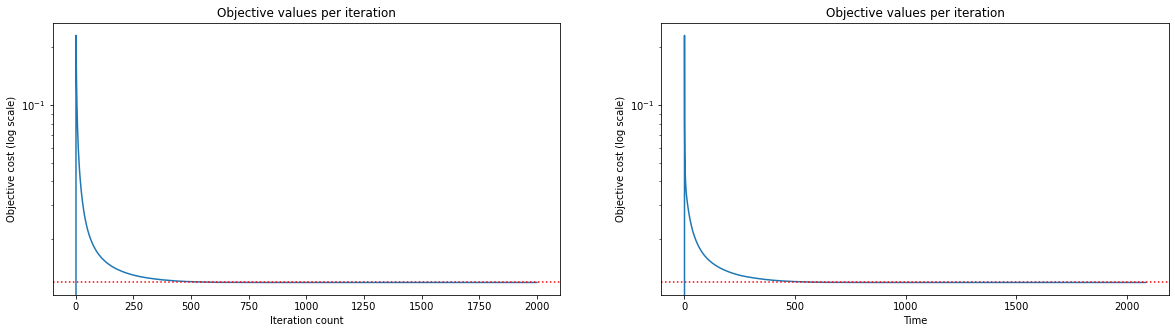

In [282]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(obj)
plt.axhline(y=γ*(obj_exact+εₐ), color='r', linestyle=':')
plt.yscale('log');    plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(np.append([0], every_iter['time']),obj)
plt.axhline(y=γ*(obj_exact+εₐ), color='r', linestyle=':')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

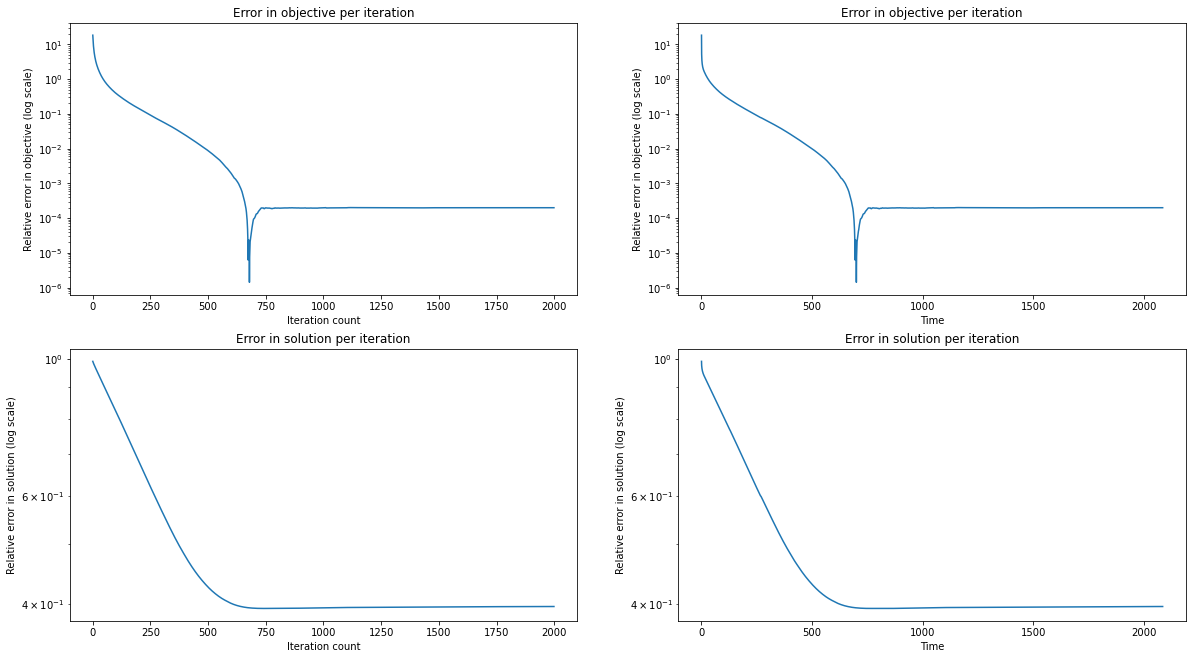

In [283]:
# Visualise evolution of relative errors
plt.figure(figsize = (20,11))

plt.subplot(2, 2, 1)
plt.plot(every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 2)
plt.plot(every_iter['time'],every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 3)
plt.plot(every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in solution (log scale)')
plt.subplot(2, 2, 4)
plt.plot(every_iter['time'],every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in solution (log scale)')

#plt.savefig(out_folder+'Rel_Error.pdf', bbox_inches='tight',transparent=True)
plt.show()

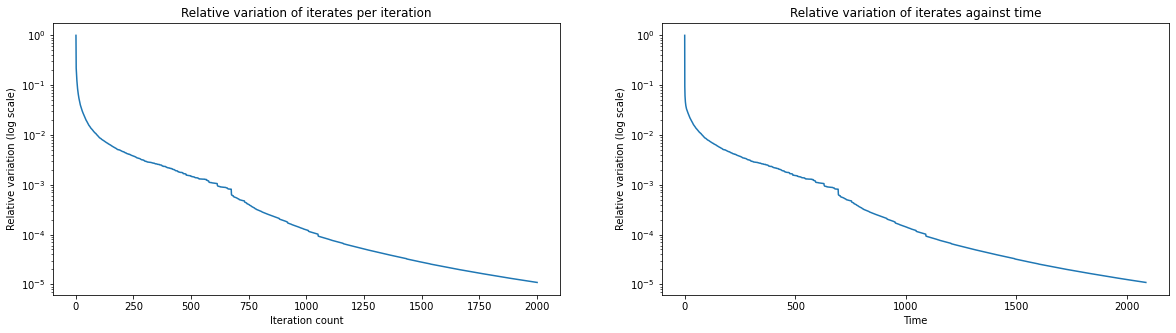

In [284]:
# Relative variation
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates per iteration')

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates against time')

#plt.savefig(out_folder+'Relative_Var.pdf', bbox_inches='tight',transparent=True)
plt.show()

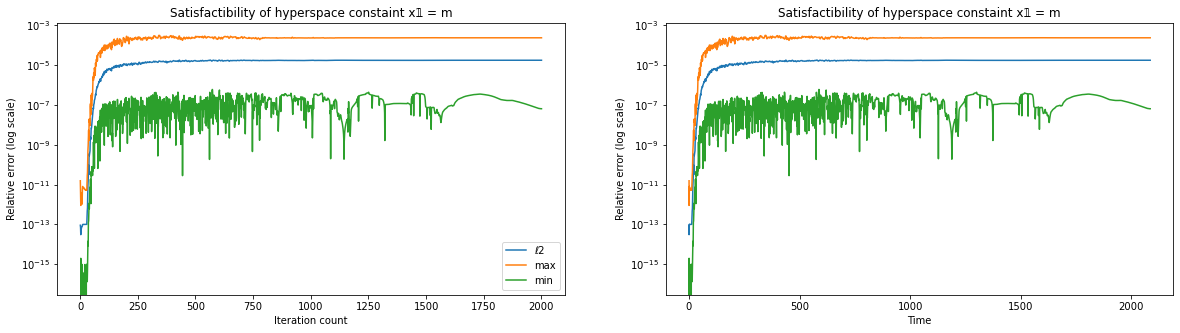

In [285]:
# Relative variation for x𝟙 = m
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')

#plt.savefig(out_folder+'RelE_m.pdf', bbox_inches='tight',transparent=True)
plt.show()

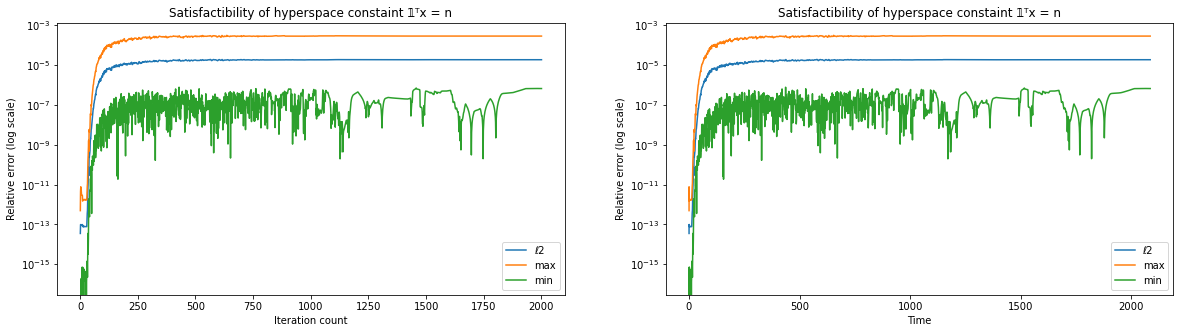

In [286]:
# Relative variation for 𝟙ᵀx = n
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

#plt.savefig(out_folder+'RelE_n.pdf', bbox_inches='tight',transparent=True)
plt.show()

Increasing iterations at proximal step:

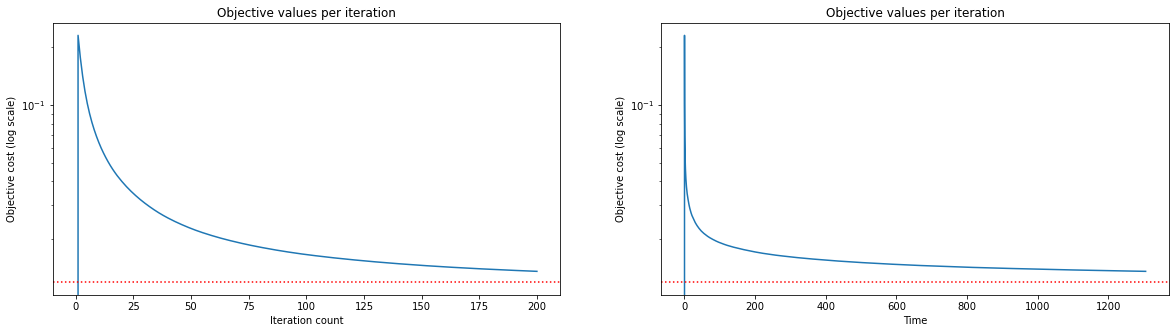

In [385]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(obj)
plt.axhline(y=γ*(obj_exact+εₐ), color='r', linestyle=':')
plt.yscale('log');    plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(np.append([0], every_iter['time']),obj)
plt.axhline(y=γ*(obj_exact+εₐ), color='r', linestyle=':')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

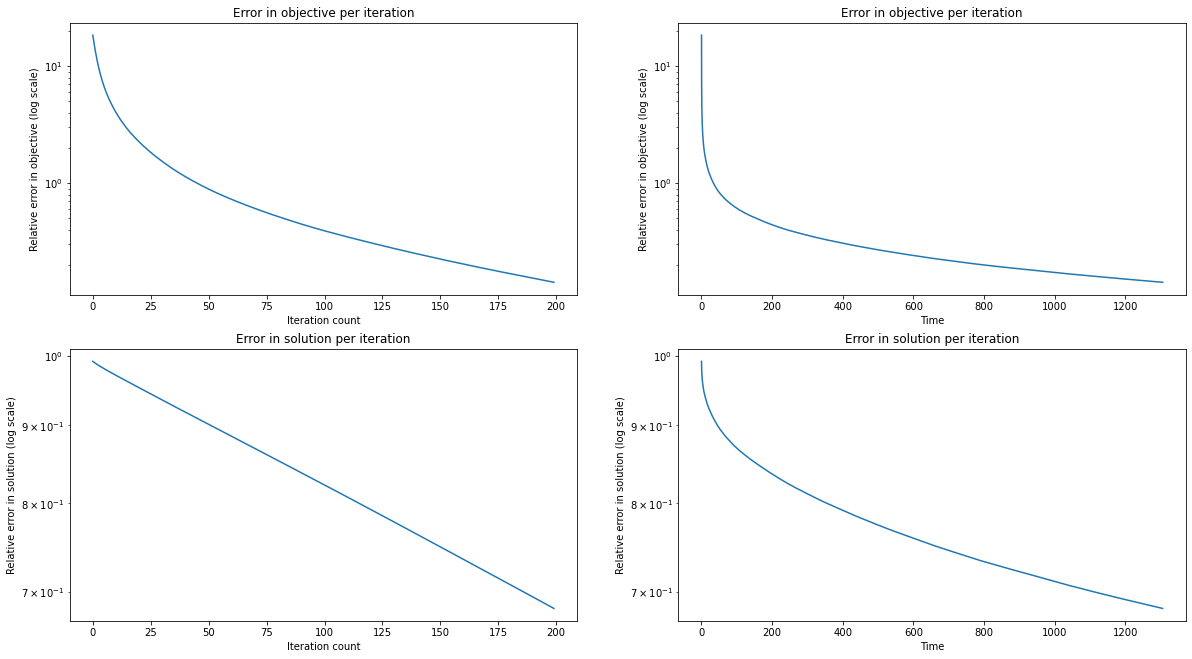

In [386]:
# Visualise evolution of relative errors
plt.figure(figsize = (20,11))

plt.subplot(2, 2, 1)
plt.plot(every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 2)
plt.plot(every_iter['time'],every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 3)
plt.plot(every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in solution (log scale)')
plt.subplot(2, 2, 4)
plt.plot(every_iter['time'],every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in solution (log scale)')

#plt.savefig(out_folder+'Rel_Error.pdf', bbox_inches='tight',transparent=True)
plt.show()

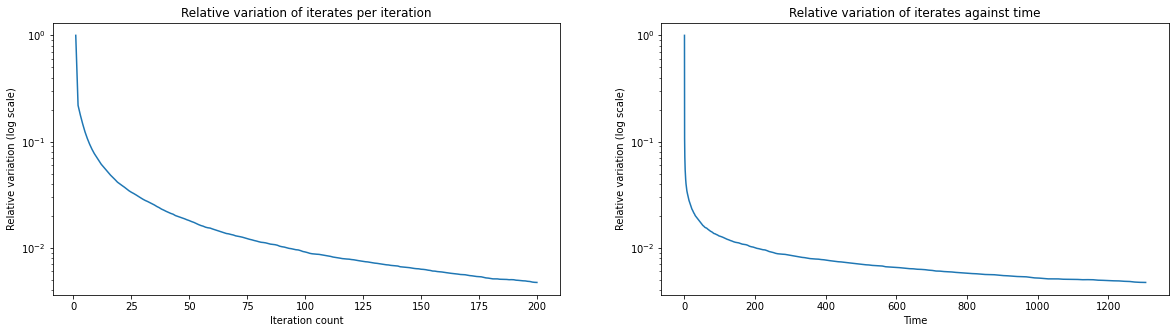

In [387]:
# Relative variation
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates per iteration')

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates against time')

#plt.savefig(out_folder+'Relative_Var.pdf', bbox_inches='tight',transparent=True)
plt.show()

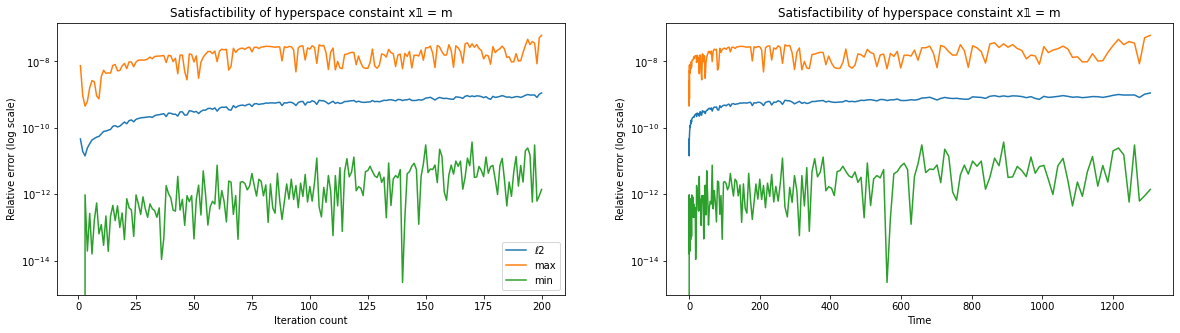

In [388]:
# Relative variation for x𝟙 = m
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')

#plt.savefig(out_folder+'RelE_m.pdf', bbox_inches='tight',transparent=True)
plt.show()

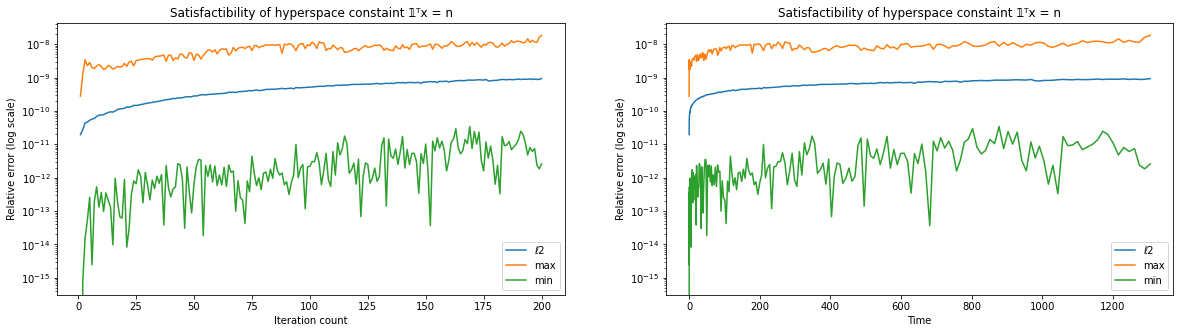

In [389]:
# Relative variation for 𝟙ᵀx = n
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

#plt.savefig(out_folder+'RelE_n.pdf', bbox_inches='tight',transparent=True)
plt.show()

Gradient restart:

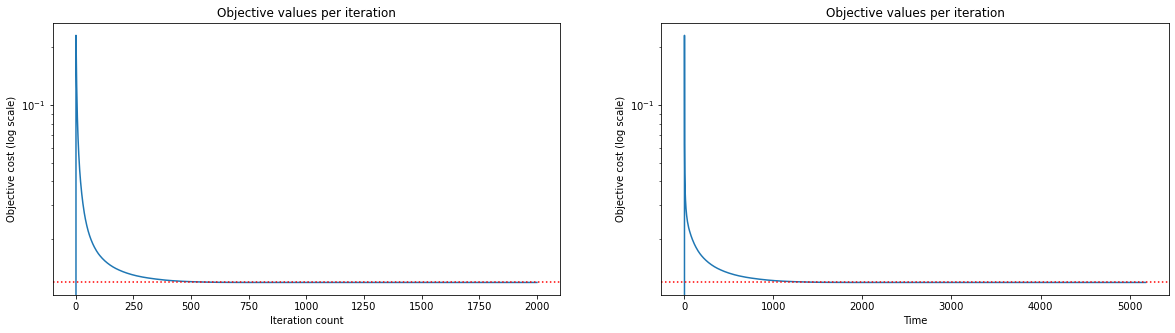

In [301]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(obj)
plt.axhline(y=γ*(obj_exact+εₐ), color='r', linestyle=':')
plt.yscale('log');    plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(np.append([0], every_iter['time']),obj)
plt.axhline(y=γ*(obj_exact+εₐ), color='r', linestyle=':')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

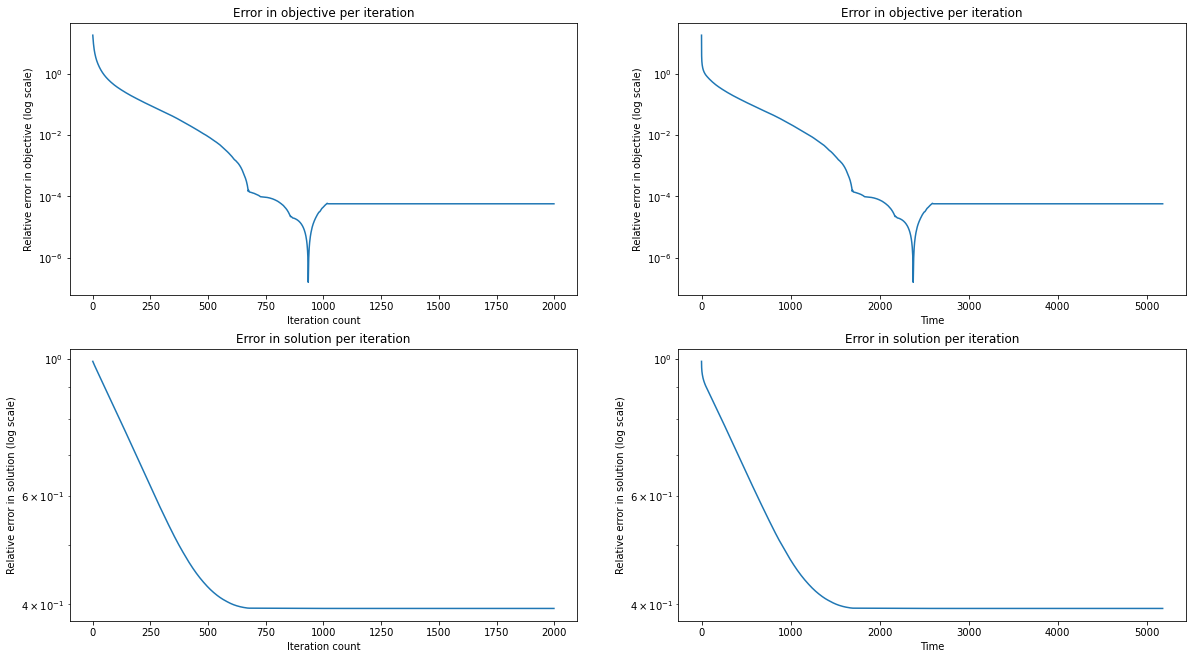

In [302]:
# Visualise evolution of relative errors
plt.figure(figsize = (20,11))

plt.subplot(2, 2, 1)
plt.plot(every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 2)
plt.plot(every_iter['time'],every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 3)
plt.plot(every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in solution (log scale)')
plt.subplot(2, 2, 4)
plt.plot(every_iter['time'],every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in solution (log scale)')

#plt.savefig(out_folder+'Rel_Error.pdf', bbox_inches='tight',transparent=True)
plt.show()

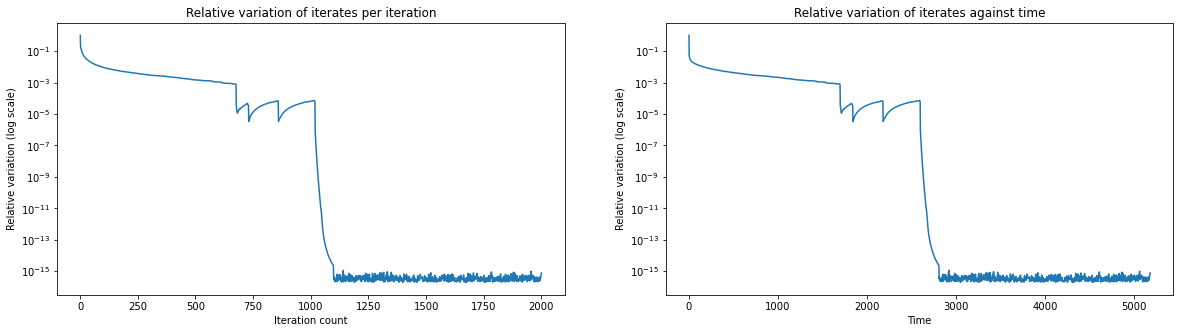

In [303]:
# Relative variation
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates per iteration')

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates against time')

#plt.savefig(out_folder+'Relative_Var.pdf', bbox_inches='tight',transparent=True)
plt.show()

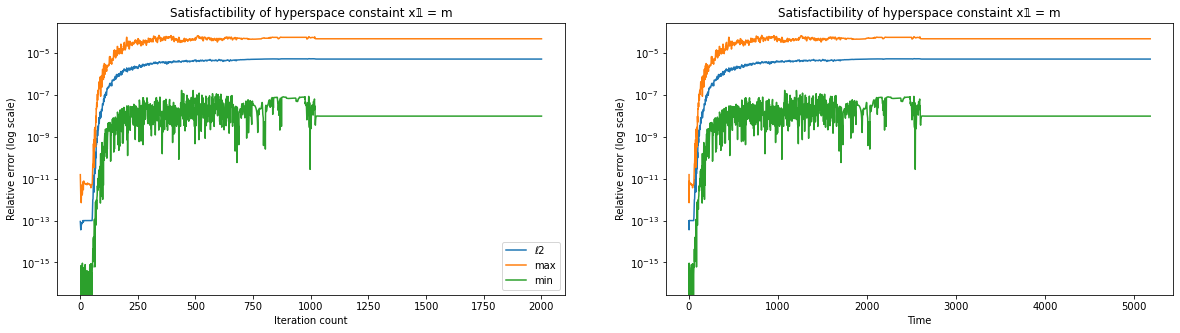

In [304]:
# Relative variation for x𝟙 = m
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')

#plt.savefig(out_folder+'RelE_m.pdf', bbox_inches='tight',transparent=True)
plt.show()

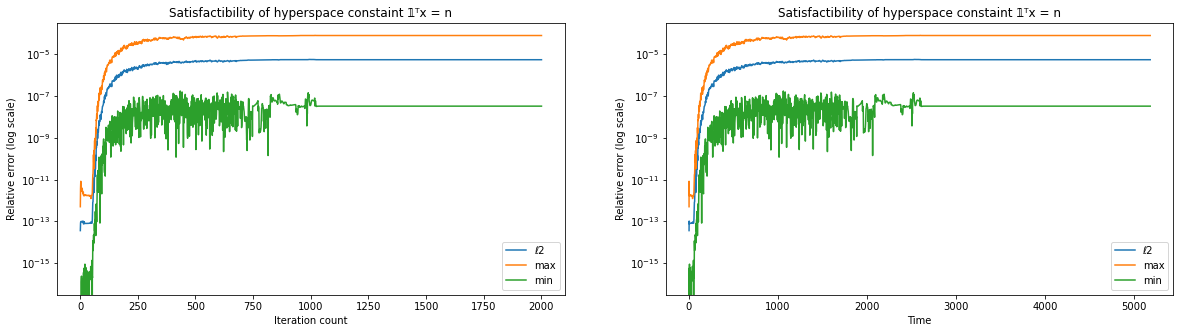

In [305]:
# Relative variation for 𝟙ᵀx = n
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

#plt.savefig(out_folder+'RelE_n.pdf', bbox_inches='tight',transparent=True)
plt.show()

## Other

All the data from the above two plots is also available as dataframes:

In [53]:
df_critical = pd.DataFrame.from_dict(every_critical)
df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
df_critical.to_excel(out_folder+'Critical.xlsx')
display(df_critical)

# If we want this table in LaTeX format run:
print(df_critical.to_latex(index=False))

,it,obj,tol,dist_obj,time,dist_x,l_1
0,7,0.011275,1.000000e+00,9.977812e-01,0.002234,1.000038,0.002002
1,68,4.580258,1.000000e-01,9.861555e-02,0.019335,0.519316,0.896478
2,102,5.031145,1.000000e-02,9.881995e-03,0.029040,0.427461,0.987001
3,129,5.076986,1.000000e-03,8.606866e-04,0.039969,0.388978,0.998212
4,130,5.080913,1.000000e-04,8.780187e-05,0.040252,0.387961,0.999059
5,192,5.081359,1.000000e-05,9.633077e-08,0.057214,0.339309,1.000188
6,842,5.081362,1.000000e-06,6.584793e-07,0.227754,0.322791,0.999969
7,1120,5.081359,1.000000e-07,4.550593e-09,0.298223,0.322769,0.999972
8,3416,5.081359,1.000000e-08,9.030682e-09,0.890367,0.322733,1.000000
9,4217,5.081359,1.000000e-09,8.442370e-10,1.102721,0.322733,1.000000


\begin{tabular}{rrrrrrr}
\toprule
    it &       obj &           tol &      dist\_obj &      time &    dist\_x &       l\_1 \\
\midrule
     7 &  0.011275 &  1.000000e+00 &  9.977812e-01 &  0.002234 &  1.000038 &  0.002002 \\
    68 &  4.580258 &  1.000000e-01 &  9.861555e-02 &  0.019335 &  0.519316 &  0.896478 \\
   102 &  5.031145 &  1.000000e-02 &  9.881995e-03 &  0.029040 &  0.427461 &  0.987001 \\
   129 &  5.076986 &  1.000000e-03 &  8.606866e-04 &  0.039969 &  0.388978 &  0.998212 \\
   130 &  5.080913 &  1.000000e-04 &  8.780187e-05 &  0.040252 &  0.387961 &  0.999059 \\
   192 &  5.081359 &  1.000000e-05 &  9.633077e-08 &  0.057214 &  0.339309 &  1.000188 \\
   842 &  5.081362 &  1.000000e-06 &  6.584793e-07 &  0.227754 &  0.322791 &  0.999969 \\
  1120 &  5.081359 &  1.000000e-07 &  4.550593e-09 &  0.298223 &  0.322769 &  0.999972 \\
  3416 &  5.081359 &  1.000000e-08 &  9.030682e-09 &  0.890367 &  0.322733 &  1.000000 \\
  4217 &  5.081359 &  1.000000e-09 &  8.442370e-10 &  

In [54]:
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['hyperₘ', 'hyperₙ'] } ),
                pd.DataFrame.from_dict( {'hyperₘ-'+a:b for a,b in every_iter['hyperₘ'].items()} ), 
                pd.DataFrame.from_dict( {'hyperₙ-'+a:b for a,b in every_iter['hyperₙ'].items()} )], axis = 1)
df_every.to_pickle(out_folder+'Every.pkl') # To read back use pd.read_pickle(file_name)
df_every.to_excel(out_folder+'Every.xlsx')
display(df_every.head())

,it,obj,dist_obj,time,dist_x,rel_var,l_1,hyperₘ-L2,hyperₘ-max,hyperₘ-min,hyperₙ-L2,hyperₙ-max,hyperₙ-min
0,0,0.0,1.0,0.000307,1.0,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,0.0,1.0,0.000617,1.0,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,0.0,1.0,0.000900,1.0,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3,0.0,1.0,0.001183,1.0,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4,0.0,1.0,0.001449,1.0,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [55]:
df_every.describe()

,it,obj,dist_obj,time,dist_x,rel_var,l_1,hyperₘ-L2,hyperₘ-max,hyperₘ-min,hyperₙ-L2,hyperₙ-max,hyperₙ-min
count,14010.000000,14010.000000,1.401000e+04,14010.000000,14010.000000,1.400300e+04,14010.000000,1.401000e+04,1.401000e+04,1.401000e+04,1.401000e+04,1.401000e+04,1.401000e+04
mean,7004.500000,5.071890,1.890637e-03,1.767095,0.325597,6.385470e-04,0.998070,2.352175e-03,1.510176e-02,7.087064e-04,2.311648e-03,9.472900e-03,7.206741e-04
std,4044.482971,0.168221,3.310398e-02,0.982835,0.033838,1.449589e-02,0.033649,3.382292e-02,1.121229e-01,2.509272e-02,3.382078e-02,8.467442e-02,2.545499e-02
min,0.000000,0.000000,0.000000e+00,0.000307,0.322492,3.056362e-14,0.000000,7.518683e-14,1.446959e-12,0.000000e+00,6.930545e-14,6.049050e-13,0.000000e+00
25%,3502.250000,5.081359,2.586294e-11,0.913386,0.322733,7.528359e-11,1.000000,2.261364e-10,1.483112e-09,4.944831e-12,2.450115e-10,2.303840e-09,2.201695e-12
50%,7004.500000,5.081359,3.630689e-09,1.830059,0.322733,1.075215e-08,1.000000,3.287569e-08,2.221965e-07,5.924812e-10,3.534928e-08,3.159324e-07,8.031149e-10
75%,10506.750000,5.081359,5.565566e-07,2.619164,0.322733,1.712423e-06,1.000000,5.199473e-06,3.900638e-05,9.781441e-08,5.546006e-06,5.004439e-05,9.429113e-08
max,14009.000000,5.104322,1.000000e+00,3.405562,1.003342,1.000000e+00,1.004226,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [56]:
# Finally, store the latest solution:
np.save(out_folder + '_Sol.npy' , x)            # To read back just run:   np.load(outfile)

---
Code used to do performance tests in each piece of code:
```Python
start = time.time()
# ...
end = time.time()
print(end-start)

%timeit -r 10 -n 200 `function(x)`
```

Not much of a speedup for interpolation:
```Python
@jit(nopython=True, fastmath = True)
def interp(xₖ,x, yₖ,y, ρ):
    return ρ*xₖ + (1 - ρ)*x, ρ*yₖ + (1 - ρ)*y

xₖ, yₖ, x, y = ones((4,M,N)); ρ = 1.9
interp(xₖ,x, yₖ,y, ρ); # Run it once
```

Let us see what happens if we compute the full projection $G$ and not its sparsified version:

In [302]:
def Marginal_G(u):
    κₘ = u.sum(1) - m
    κₙ = u.sum(0) - n

    βₘ = κₘ.sum() / (M + N)        # dim M
    βₙ = κₙ.sum() / (M + N)        # dim N

    # Return yₖ = ( (κₘ - βₘ)/N).reshape(M,1) + (κₙ - βₙ)/M
    return ( (κₘ - βₘ)/N ).reshape(M,1) + (κₙ - βₙ)/M

In [332]:
# Initialise variables
xₖ = zeros((M,N));       # Algorithm quite quick if initial point is at least in [0,1] with sum < 1
# tried: c/c.sum() and works like a charm.
qₖ, pₖ, uₖ, yₖ, vₖ = zeros((5,M,N));

In [333]:
Errors = {'m':[], 'n':[], '<0':[], '>1':[]}

In [334]:
# Dykstra’s projection method
for i in range(4000):
    # Store xₖ + pₖ
    add(xₖ,pₖ,uₖ);
    # Update pₖ
    pₖ = Marginal_G(uₖ)
    # Update yₖ = uₖ - pₖ
    subtract(uₖ,pₖ,yₖ);
    # Store yₖ + qₖ
    add(yₖ,qₖ,vₖ);
    # Update xₖ = [yₖ + qₖ]_+
    maximum(vₖ, 0.0, xₖ);
    # Update qₖ = [yₖ + qₖ]_-
    minimum(vₖ, 0.0, qₖ);
    
    # Test error
    r, s = xₖ.sum(1) - m, xₖ.sum(0) - n
    
    # Constrained satisfactibility
    Errors['m'].append( norm(r)/norm(m) )
    Errors['n'].append( norm(s)/norm(n) )
    Errors['<0'].append( (xₖ < 0.0).any() )
    Errors['>1'].append( (xₖ > 1.0).any() )
    
    if max(Errors['m'][-1], Errors['n'][-1]) < 1e-13:
        break

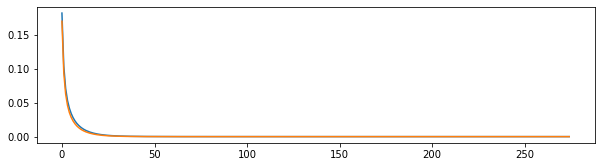

In [335]:
plt.figure(figsize=(10,2.5))
plt.plot(Errors['m'])
plt.plot(Errors['n'])
plt.show()

---